In [4]:
from datetime import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
#I want to plot output price vs release date
import matplotlib.pyplot as plt

#read in csv file and convert to pandas dataframe
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates
from statsmodels.regression.quantile_regression import QuantReg
import statsmodels.api as sm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression, QuantileRegressor

In [5]:

df = pd.read_csv('art_analysis_inf_data.csv')
print(df.columns)
#convert price to float
df['Output Price\nUSD/1M Tokens'] = df['Output Price\nUSD/1M Tokens'].str.replace('$', '').astype(float)
df['Lowest Blended Price AA'] = df['Lowest Blended Price AA'].astype(float)
df['Blended\nUSD/1M Tokens'] = df['Blended\nUSD/1M Tokens'].str.replace('$', '').astype(float)


#convert release date to datetime where release date is not nan
df['Release Date'] = pd.to_datetime(df['Release Date'])



# # Create Active Parameters column by choosing Known Active Parameters when available, otherwise use Parameters
df['Active Parameters'] = np.where(
    df['Known Active Parameters'].notna(),
    df['Known Active Parameters'],
    df['Parameters']
)

#print the first 5 rows of the datafr

Index(['Model', 'Creator', 'License', 'Context\nWindow',
       'Artificial Analysis\nIntelligence Index',
       'MMLU-Pro (Reasoning & Knowledge)',
       'GPQA Diamond (Scientific Reasoning)',
       'Humanity's Last Exam (Reasoning & Knowledge)',
       'LiveCodeBench (Coding)', 'SciCode (Coding)', 'HumanEval (Coding)',
       'MATH-500 (Quantitative Reasoning)', 'AIME 2024 (Competition Math)',
       'Multilingual Index (Artificial Analysis)', 'Chatbot Arena',
       'Blended\nUSD/1M Tokens', 'Input Price\nUSD/1M Tokens',
       'Output Price\nUSD/1M Tokens', 'Median\nTokens/s', 'P5\nTokens/s',
       'P25\nTokens/s', 'P75\nTokens/s', 'P95\nTokens/s',
       'Median\nFirst Chunk (s)', 'First Answer\nToken (s)',
       'P5\nFirst Chunk (s)', 'P25\nFirst Chunk (s)', 'P75\nFirst Chunk (s)',
       'P95\nFirst Chunk (s)', 'Total\nResponse (s)', 'Reasoning\nTime (s)',
       'Further\nAnalysis', 'Release Date', 'Parameters',
       'Known Active Parameters', 'Lowest Output Price Found 

/var/folders/lp/hk0h_6g94b59251kmlwhp32h0000gn/T/ipykernel_77898/2965051322.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Release Date'] = pd.to_datetime(df['Release Date'])


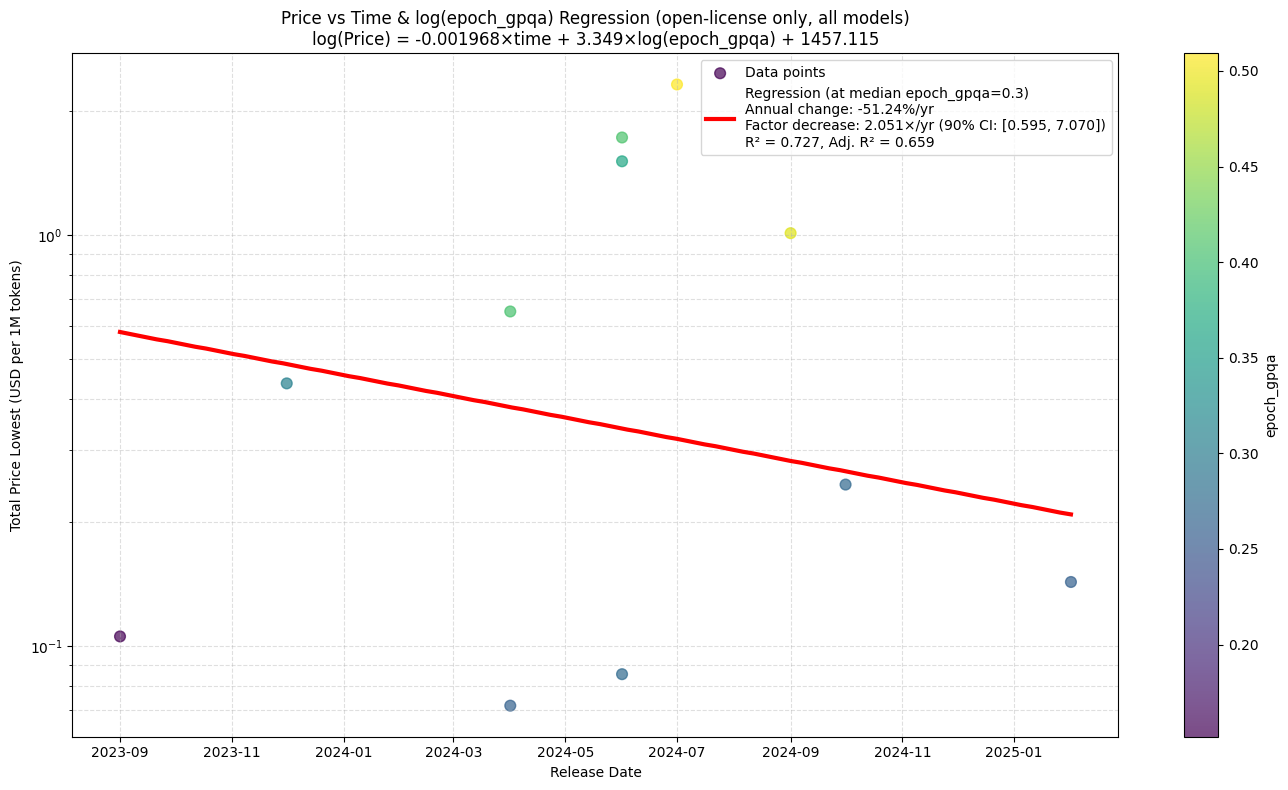


Regression Results:
Model: log(Price) = -0.001968×time + 3.349×log(epoch_gpqa) + 1457.115
R² score: 0.7269
Adjusted R² score: 0.6586

Time coefficient (alpha): -0.001968
Annual percentage change: -51.24%/yr
Annual factor decrease: 2.051×/yr
90% CI for factor decrease: [0.595, 7.070]
log(epoch_gpqa) coefficient (beta): 3.349
Intercept (c): 1457.115

Data points used: 11


In [6]:
def plot_price_benchmark_regression(df, benchmark1_col, benchmark2_col, open_license_only=False, 
                                  min_benchmark1=None, max_benchmark1=None, 
                                  price_column='total price lowest', 
                                  exclude_dominated=False):
    """
    Plot log(Price) = alpha*time + beta*log(epoch_gpqa) + c regression
    
    Parameters:
    - df: DataFrame with the model data
    - benchmark1_col: Name of the first benchmark column to use (not used, kept for compatibility)
    - benchmark2_col: Name of the second benchmark column to use (not used, kept for compatibility)
    - open_license_only: If True, only include models with open licenses
    - min_benchmark1: Minimum score for first benchmark to include (optional, not used)
    - max_benchmark1: Maximum score for first benchmark to include (optional, not used)
    - price_column: Column name for price data (default: 'total price lowest')
    - exclude_dominated: If True, exclude models that are Pareto dominated by earlier models
    
    Returns fitted model coefficients and annual decrease rates
    """
    # Column names
    price_col = price_column
    license_col = 'License'
    epoch_col = 'epoch_gpqa'
    
    # Work on a copy
    df_work = df.copy()
    
    # Convert epoch_gpqa to numeric
    df_work[epoch_col] = pd.to_numeric(df_work[epoch_col], errors='coerce')
    
    # Convert price to float
    df_work[price_col] = pd.to_numeric(df_work[price_col], errors='coerce')
    
    # Optionally filter to open-license only
    if open_license_only:
        df_work = df_work[
            df_work[license_col].notna() &
            df_work[license_col].str.contains('open', case=False, na=False)
        ]
    
    # Filter to rows with all necessary data
    required_cols = ['Release Date', price_col, epoch_col]
    df_sub = df_work.dropna(subset=required_cols)
    df_sub = df_sub[(df_sub[price_col] > 0) & (df_sub[epoch_col] > 0)]
    
    # Optionally filter out Pareto dominated models
    if exclude_dominated:
        df_sub = df_sub.sort_values('Release Date')
        non_dominated = []
        
        for i, row in df_sub.iterrows():
            # Check if this model is dominated by any previous model
            dominated = False
            for j in non_dominated:
                prev_row = df_sub.loc[j]
                # A model is dominated if there exists a previous model with:
                # 1. Better or equal epoch_gpqa AND
                # 2. Lower or equal price
                if (prev_row[epoch_col] >= row[epoch_col] and 
                    prev_row[price_col] <= row[price_col] and
                    (prev_row[epoch_col] > row[epoch_col] or 
                     prev_row[price_col] < row[price_col])):
                    dominated = True
                    break
            
            if not dominated:
                non_dominated.append(i)
                
                # Also remove any previously added models that this one dominates
                new_non_dominated = []
                for j in non_dominated[:-1]:  # All except the one we just added
                    prev_row = df_sub.loc[j]
                    if not (row[epoch_col] >= prev_row[epoch_col] and 
                           row[price_col] <= prev_row[price_col] and
                           (row[epoch_col] > prev_row[epoch_col] or 
                            row[price_col] < prev_row[price_col])):
                        new_non_dominated.append(j)
                
                non_dominated = new_non_dominated + [i]
        
        df_sub = df_sub.loc[non_dominated]
    
    if len(df_sub) < 3:  # Need at least 3 points for 2 predictors + intercept
        print(f"Warning: Only {len(df_sub)} data points available. Need at least 3 for regression with time and epoch_gpqa.")
        return None, None, None
    
    # Prepare variables for regression
    df_sub = df_sub.sort_values('Release Date').copy()
    df_sub['Date_Ordinal'] = df_sub['Release Date'].map(datetime.toordinal)
    
    # Features: time, log(epoch_gpqa)
    X = np.column_stack([
        df_sub['Date_Ordinal'].values,
        np.log(df_sub[epoch_col].values)
    ])
    
    # Target: log(total price lowest)
    y = np.log(df_sub[price_col].values)
    
    # Fit linear regression
    model = LinearRegression().fit(X, y)
    alpha, beta = model.coef_
    c = model.intercept_
    r2 = model.score(X, y)
    
    # Calculate adjusted R²
    n = len(df_sub)
    p = 2  # number of predictors
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
    
    # Calculate annual decrease rates
    annual_log_change = alpha * 365
    annual_pct_change = (np.exp(annual_log_change) - 1) * 100
    factor_change_per_year = np.exp(annual_log_change)
    
    # Express as factor decrease if price is decreasing
    if factor_change_per_year < 1:
        factor_decrease_per_year = 1 / factor_change_per_year
    else:
        factor_decrease_per_year = None
    
    # Calculate confidence intervals for the time coefficient
    y_pred = model.predict(X)
    residuals = y - y_pred
    mse = np.sum(residuals**2) / (n - p - 1)
    
    # Calculate variance-covariance matrix
    X_mean_centered = X - np.mean(X, axis=0)
    cov_matrix = np.linalg.inv(X_mean_centered.T.dot(X_mean_centered)) * mse
    
    # Standard error for alpha (time coefficient)
    se_alpha = np.sqrt(cov_matrix[0, 0])
    se_annual = se_alpha * 365
    
    # t-statistic for 90% confidence interval
    from scipy import stats
    t_stat = stats.t.ppf(0.95, n - p - 1)
    
    # Confidence interval for annual log change
    annual_log_change_lower = annual_log_change - t_stat * se_annual
    annual_log_change_upper = annual_log_change + t_stat * se_annual
    
    # Convert to factor change confidence interval
    factor_change_lower = np.exp(annual_log_change_lower)
    factor_change_upper = np.exp(annual_log_change_upper)
    
    # Express as factor decrease for confidence interval if price is decreasing
    if factor_change_per_year < 1:
        factor_decrease_lower = 1 / factor_change_upper
        factor_decrease_upper = 1 / factor_change_lower
    else:
        factor_decrease_lower = None
        factor_decrease_upper = None
    
    # Generate predictions for plotting
    min_ord, max_ord = df_sub['Date_Ordinal'].min(), df_sub['Date_Ordinal'].max()
    x_range = np.linspace(min_ord, max_ord, 100)
    x_dates = [datetime.fromordinal(int(d)) for d in x_range]
    
    # For visualization, show trend at median values
    median_epoch = df_sub[epoch_col].median()
    
    X_pred = np.column_stack([
        x_range,
        np.full(len(x_range), np.log(median_epoch))
    ])
    y_pred = model.predict(X_pred)
    
    # Plot results
    plt.figure(figsize=(14, 8))
    
    # Color points by epoch_gpqa
    scatter = plt.scatter(
        df_sub['Release Date'], 
        df_sub[price_col],
        c=df_sub[epoch_col], 
        cmap='viridis', 
        alpha=0.7,
        s=60,
        label='Data points'
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label(f'{epoch_col}')
    
    # Plot regression line (at median values)
    if factor_decrease_per_year:
        regression_label = (f'Regression (at median {epoch_col}={median_epoch:.1f})\n'
                           f'Annual change: {annual_pct_change:.2f}%/yr\n'
                           f'Factor decrease: {factor_decrease_per_year:.3f}×/yr (90% CI: [{factor_decrease_lower:.3f}, {factor_decrease_upper:.3f}])\n'
                           f'R² = {r2:.3f}, Adj. R² = {adjusted_r2:.3f}')
    else:
        regression_label = (f'Regression (at median {epoch_col}={median_epoch:.1f})\n'
                           f'Annual change: {annual_pct_change:.2f}%/yr\n'
                           f'Factor change: {factor_change_per_year:.3f}×/yr (90% CI: [{factor_change_lower:.3f}, {factor_change_upper:.3f}])\n'
                           f'R² = {r2:.3f}, Adj. R² = {adjusted_r2:.3f}')
    
    plt.plot(x_dates, np.exp(y_pred), 'r-', lw=3, label=regression_label)
    
    plt.yscale('log')
    plt.xlabel('Release Date')
    plt.ylabel('Total Price Lowest (USD per 1M tokens)')
    
    lic_label = 'open-license only' if open_license_only else 'all licenses'
    pareto_label = "non-dominated models only" if exclude_dominated else "all models"
    
    plt.title(f'Price vs Time & log(epoch_gpqa) Regression ({lic_label}, {pareto_label})\n'
              f'log(Price) = {alpha:.6f}×time + {beta:.3f}×log(epoch_gpqa) + {c:.3f}')
    
    plt.grid(True, which='both', ls='--', alpha=0.4)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    # Print detailed results
    print(f"\nRegression Results:")
    print(f"Model: log(Price) = {alpha:.6f}×time + {beta:.3f}×log(epoch_gpqa) + {c:.3f}")
    print(f"R² score: {r2:.4f}")
    print(f"Adjusted R² score: {adjusted_r2:.4f}")
    print(f"\nTime coefficient (alpha): {alpha:.6f}")
    print(f"Annual percentage change: {annual_pct_change:.2f}%/yr")
    
    if factor_decrease_per_year:
        print(f"Annual factor decrease: {factor_decrease_per_year:.3f}×/yr")
        print(f"90% CI for factor decrease: [{factor_decrease_lower:.3f}, {factor_decrease_upper:.3f}]")
    else:
        print(f"Annual factor change: {factor_change_per_year:.3f}×/yr")
        print(f"90% CI for factor change: [{factor_change_lower:.3f}, {factor_change_upper:.3f}]")
    
    print(f"log(epoch_gpqa) coefficient (beta): {beta:.3f}")
    print(f"Intercept (c): {c:.3f}")
    print(f"\nData points used: {len(df_sub)}")
    
    return model, df_sub, {
        'alpha': alpha,
        'beta': beta,
        'c': c,
        'annual_pct_change': annual_pct_change,
        'factor_change_per_year': factor_change_per_year,
        'factor_decrease_per_year': factor_decrease_per_year if factor_change_per_year < 1 else None,
        'factor_change_ci_lower': factor_change_lower,
        'factor_change_ci_upper': factor_change_upper,
        'factor_decrease_ci_lower': factor_decrease_lower if factor_change_per_year < 1 else None,
        'factor_decrease_ci_upper': factor_decrease_upper if factor_change_per_year < 1 else None,
        'r2_score': r2,
        'adjusted_r2_score': adjusted_r2
    }

# Example usage:
model, data, results = plot_price_benchmark_regression(
    df, 
    benchmark1_col="MMLU-Pro (Reasoning & Knowledge)", 
    benchmark2_col="SciCode (Coding)",
    min_benchmark1=40,
    max_benchmark1=70,
    open_license_only=True, 
    price_column="total price lowest", 
    exclude_dominated=False
)